# HousingPrices
Implement from scratch the ridge regression algorithm for regression with square loss.

Apply the algorithm to the prediction of the label medianHouseValue in this dataset.

Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression.

Try using PCA to improve the risk estimate.

Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.

Here is a description of the attributes in the dataset:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

Note: The dataset has an attribute with missing values and an attribute with categorical values. Find a way of handling these anomalies and justify your choice.


## License
Copyright 2020 (c) Anna Olena Zhab'yak, Michele Maione. All rights reserved.

Licensed under the [MIT](LICENSE) License.

----------------
# Ridge regression
This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
minimize two elements, the RSS and the objective function 

In ridge regression two elements are optimized , the RSS and the objective function

$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $

It is a variation of the Linear regression with a tunning parameter alpha to control model complexity.
need to do a trade off between variance and bias
1. the inhability for the model to capture the true relationship is called bias. How well the model fits our data 
2. how well model does on a completely new dataset. 

use the hyper parameter called alpha , to add a bias , prevent the model from real, it will have better accurancy on the testing set, it means it will not overfit in the training set.  

## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression. First, let's download the libraries 

In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV

from plotting import Plotting
from svd import SVD
from cholesky import Cholesky
from lasso import Lasso

----------------
## Dataset analysis
Open the database, check the structure, show the head, take a look of its structure, the descriptive statistics and manage the columns.

Create the constants

The target value is the median_house_value which is predicted based on the features of different houses.

### Mean squared error
The mean squared error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

### R²
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

In [2]:
scoring = 'r2'
scoring_neg = False
scoring_label = 'R²'
scoring_label_loss = 'R²'

#scoring = 'neg_mean_squared_error'
#scoring_neg = True
#scoring_label = 'MSE'
#scoring_label_loss = 'Squared loss'

Create the constants

In [3]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [4]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

In [5]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [6]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Here is the distribution of the values of the target variable "median_house_value".
It looks like a normal distribution with a group of outliers on the highest value of the house.

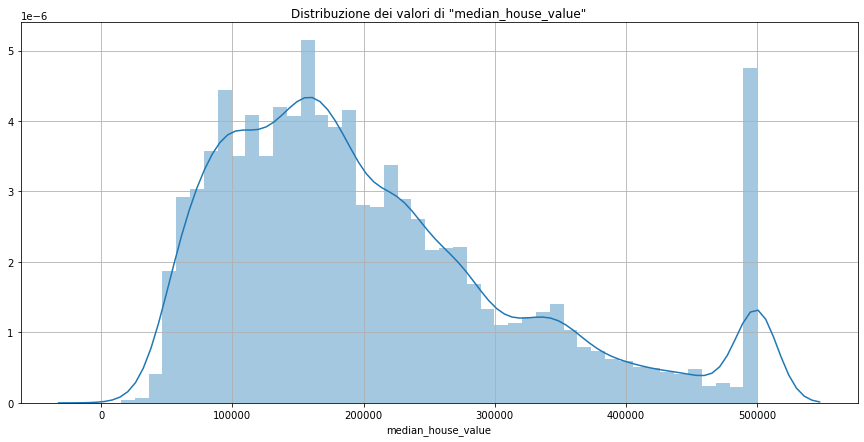

In [8]:
Plotting.distPlot(data_frame[column_to_predict], 'Distribuzione dei valori di "median_house_value"')

----------------
## Data pre-processing

### Outliers

In [9]:
outliers = data_frame[data_frame[column_to_predict] == 500001].index

print(f'There are {len(outliers)} outliers')

#data_frame.drop(outliers, inplace=True)

There are 965 outliers


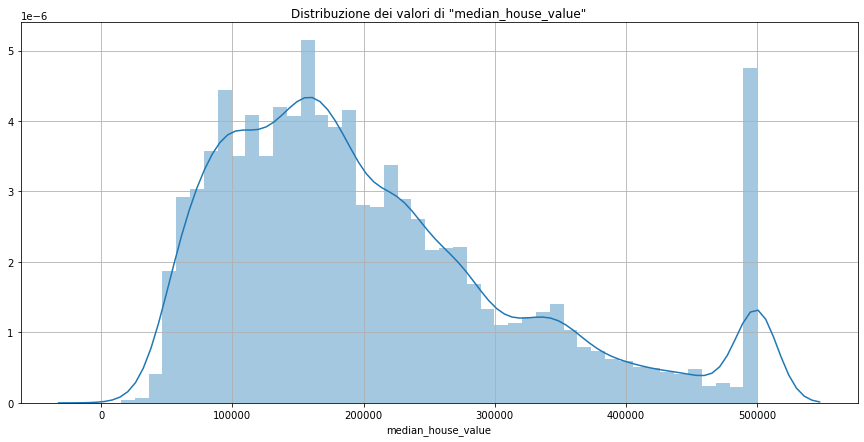

In [10]:
Plotting.distPlot(data_frame[column_to_predict], 'Distribuzione dei valori di "median_house_value"')

###  Missing values
The dataset contains missing values which are handeled by replacing the value with the mean value of the column. This procedure is necessary to avoid errors in the execution.

In [11]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

### Categorical feature
Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers.

In [12]:
useLabelEncoder = False
useColumnCat = True

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)
elif useColumnCat:
    # genera le colonne per ogni elemento di una colonna categoria
    columns_categories = pandas.DataFrame()

    for c in categories_columns:
        column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')        
        columns_categories = pandas.concat((columns_categories, column), axis=1)

    for col in columns_categories.columns: 
        numerics_columns.append(col)
        
    # elimina le colonne categoria
    data_frame.drop(columns=categories_columns, inplace=True)

    # aggiungi le colonne per ogni elemento di una colonna categoria
    data_frame = pandas.concat([data_frame, columns_categories], axis=1)
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND', 'NEAR BAY'], [1, 2, 3, 4, 5], inplace=True)
    numerics_columns.append('ocean_proximity')

data_frameOriginal = data_frame.copy(deep=True)

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 

Equazioni esempio:

$$ \hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j}  $$

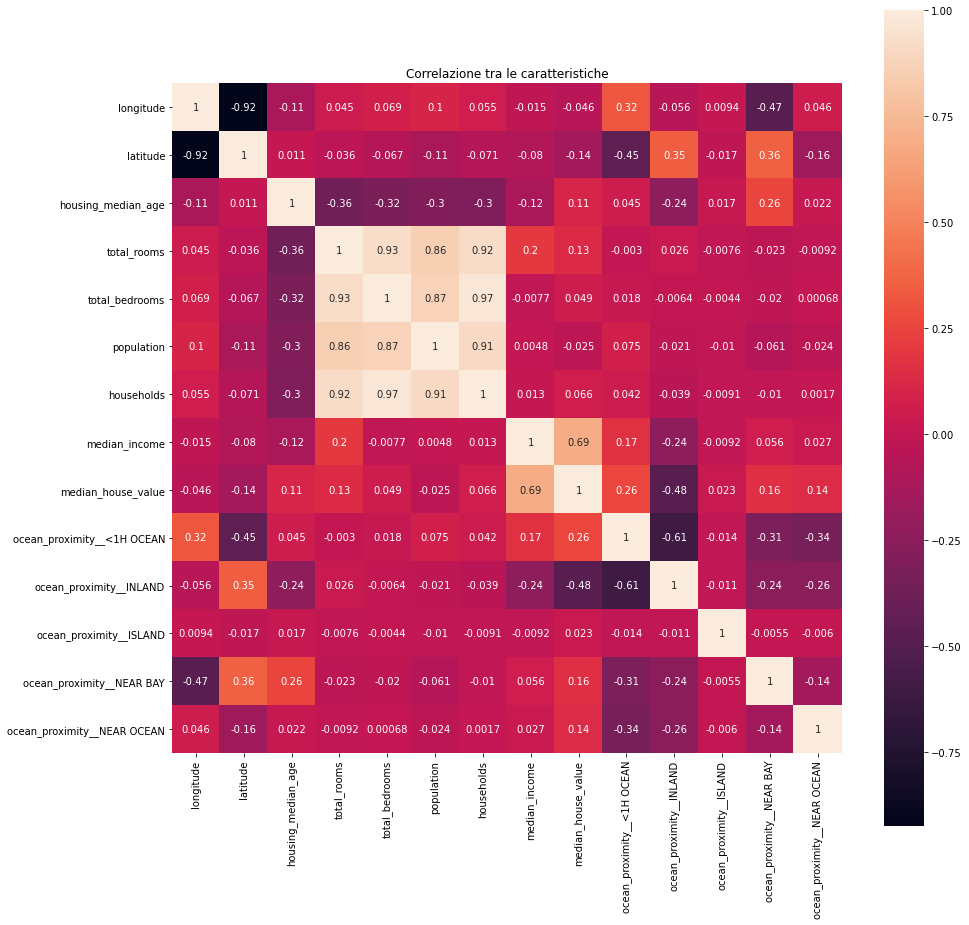

In [13]:
corr = data_frame.corr()
Plotting.heatMap(corr, 'Correlazione tra le caratteristiche')

Pearson's coefficient is determined by :

$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [14]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.927253,0.857126,0.918484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.927253,NaN,0.873910,0.974725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.857126,0.873910,NaN,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.918484,0.974725,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see the pairs of the most correlated features are 
(households - total_bedrooms)
(population - housegìholds)
(total_rooms - total_bedrooms)
(total_bedroom - households)

Delete the correlated features
1. latitude
2. population 
3. total_rooms

In [15]:
#columns_to_remove = ['latitude', 'population', 'total_rooms']
#columns_to_remove = ['households', 'total_bedrooms']
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [16]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


Quindi la nostra attuale y è la seguente:

In [17]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

----------------
## Scaler
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

This transformation is often used as an alternative to zero mean, unit variance scaling.

In [18]:
column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
cols = list(range(0, data_frame.shape[1]))
cols.remove(column_to_predict_idx)

#scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = Normalizer()

#scaler.fit(data_frame)
#data_frame = scaler.transform(data_frame)
#data_frame = pandas.DataFrame(data_frame, columns=columns_to_use)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [19]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


In [20]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

----------------
## Learning algorithm
Before starting to learn the algorithm, the dataset must be splitted in subsets in order to preserve some data for the validation of the method.

In [21]:
alphas = numpy.sort(numpy.linspace(1, 0, 11, False))
alphas

array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
       0.54545455, 0.63636364, 0.72727273, 0.81818182, 0.90909091,
       1.        ])

In [22]:
cholesky = Cholesky()
svd = SVD()

lasso = Lasso()

### Validation curve
Dal grafico possiamo dedurre che per la Ridge bisogna dare almeno il XX% di Training set

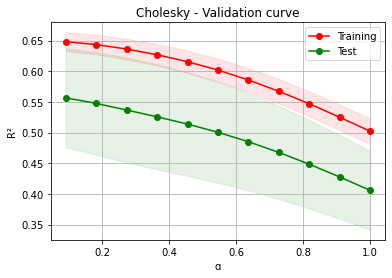

In [23]:
train_score, val_score = validation_curve(cholesky, X, y, param_name="alpha", param_range=alphas, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Cholesky - Validation curve',
    alphas,
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'ɑ',
    scoring_label_loss)

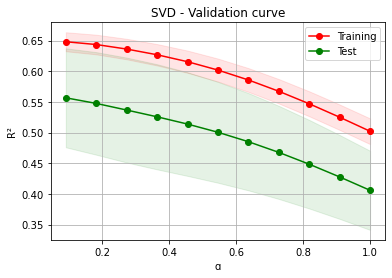

In [24]:
train_score, val_score = validation_curve(svd, X, y, param_name="alpha", param_range=alphas, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'SVD - Validation curve',
    alphas,
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'ɑ',
    scoring_label_loss)

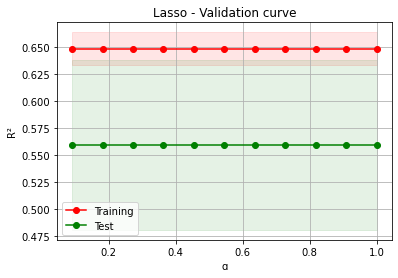

In [25]:
train_score, val_score = validation_curve(lasso, X, y, param_name="alpha", param_range=alphas, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Lasso - Validation curve',
    alphas,
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'ɑ',
    scoring_label_loss)

In [26]:
min_ts = int(X.shape[0] * 0.3)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(6192, 16512, 2064)


### Learning curve
Dal grafico possiamo dedurre che per la Ridge bisogna dare almeno il 70% di Training set

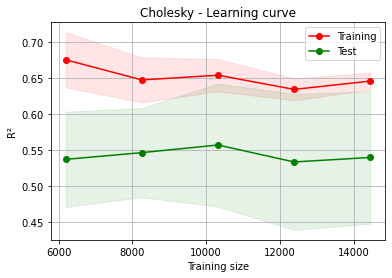

In [27]:
cholesky.alpha = 0.1
train_size, train_score, val_score = learning_curve(cholesky, X, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Cholesky - Learning curve', 
    sizes, 
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

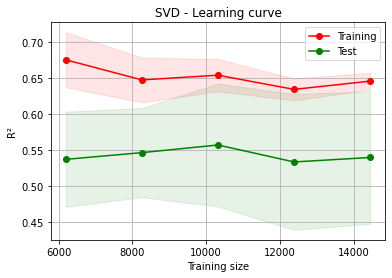

In [28]:
svd.alpha = 0.1
train_size, train_score, val_score = learning_curve(svd, X, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'SVD - Learning curve', 
    sizes, 
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

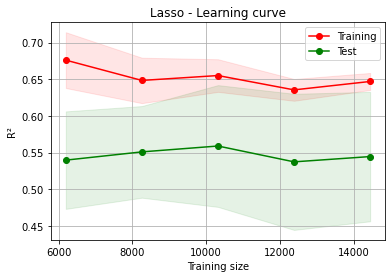

In [29]:
lasso.alpha = 1
train_size, train_score, val_score = learning_curve(lasso, X, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Lasso - Learning curve', 
    sizes, 
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

### Train & Test
Train 70%, Test 30%

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### Elaborazione per range di ɑ

In [31]:
cholesky.calculateScoring(alphas, x_train, y_train, x_test, y_test)
cholesky.printBestScores()

Cholesky:
-best ɑ: 0.09090909090909083
-best MSE: 4855808814.745185
-best R²: 0.63552489324503


In [32]:
svd.calculateScoring(alphas, x_train, y_train, x_test, y_test)
svd.printBestScores()

SVD:
-best ɑ: 0.09090909090909083
-best MSE: 4855808814.745185
-best R²: 0.6355248932450301


In [33]:
lasso.calculateScoring(alphas, x_train, y_train, x_test, y_test)
lasso.printBestScores()

Lasso:
-best ɑ: 1.0
-best MSE: 4841582602.467993
-best R²: 0.6365927071636308


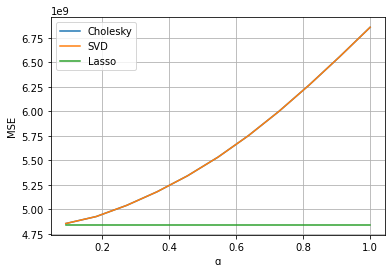

In [34]:
Plotting.plotXY(alphas, [cholesky.MSE, svd.MSE, lasso.MSE], [cholesky.algo, svd.algo, lasso.algo], 'ɑ', 'MSE')

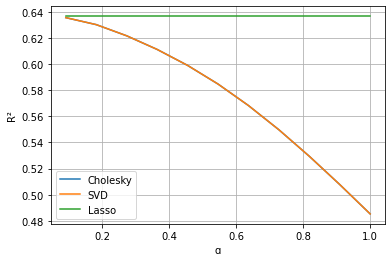

In [35]:
Plotting.plotXY(alphas, [cholesky.R2, svd.R2, lasso.R2], [cholesky.algo, svd.algo, lasso.algo], 'ɑ', 'R²')

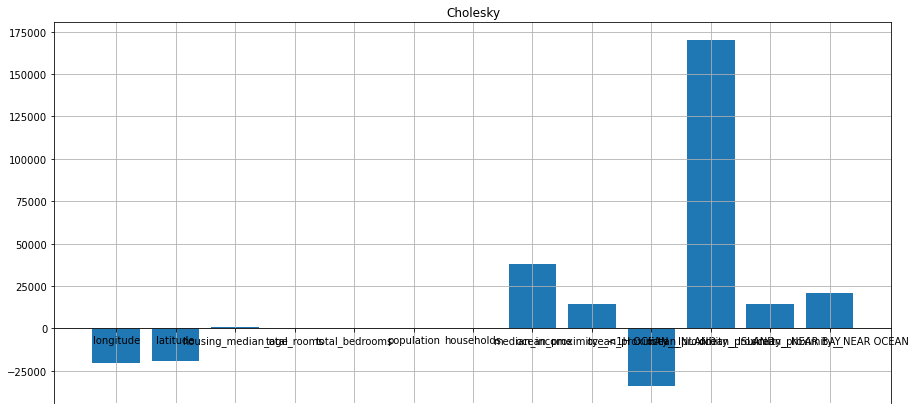

In [36]:
cholesky.fit(x_train, y_train)
y_predict_c = cholesky.predict(x_test)
Plotting.coeficientPlot('Cholesky', x_train, cholesky.coef_)

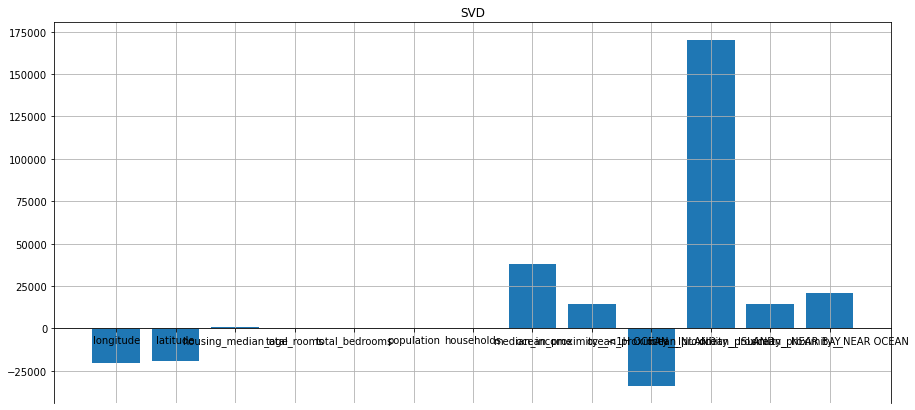

In [37]:
svd.fit(x_train, y_train)
y_predict_s = lasso.predict(x_test)
Plotting.coeficientPlot('SVD', x_train, svd.coef_)

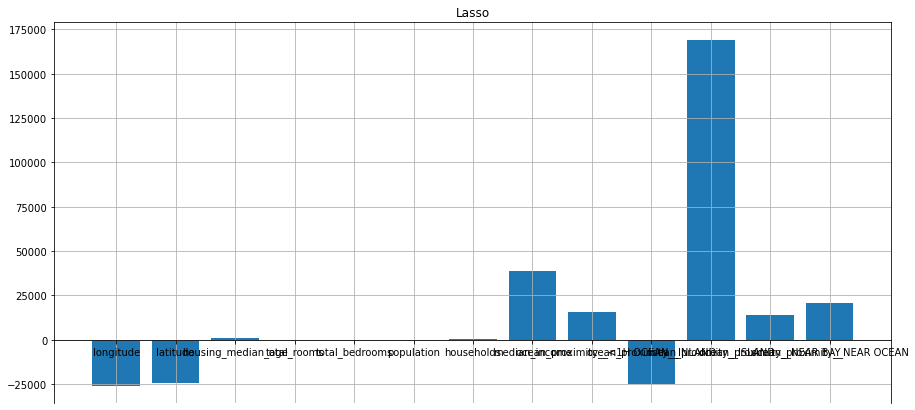

In [38]:
lasso.fit(x_train, y_train)
y_predict_l = lasso.predict(x_test)
Plotting.coeficientPlot('Lasso', x_train, lasso.coef_)

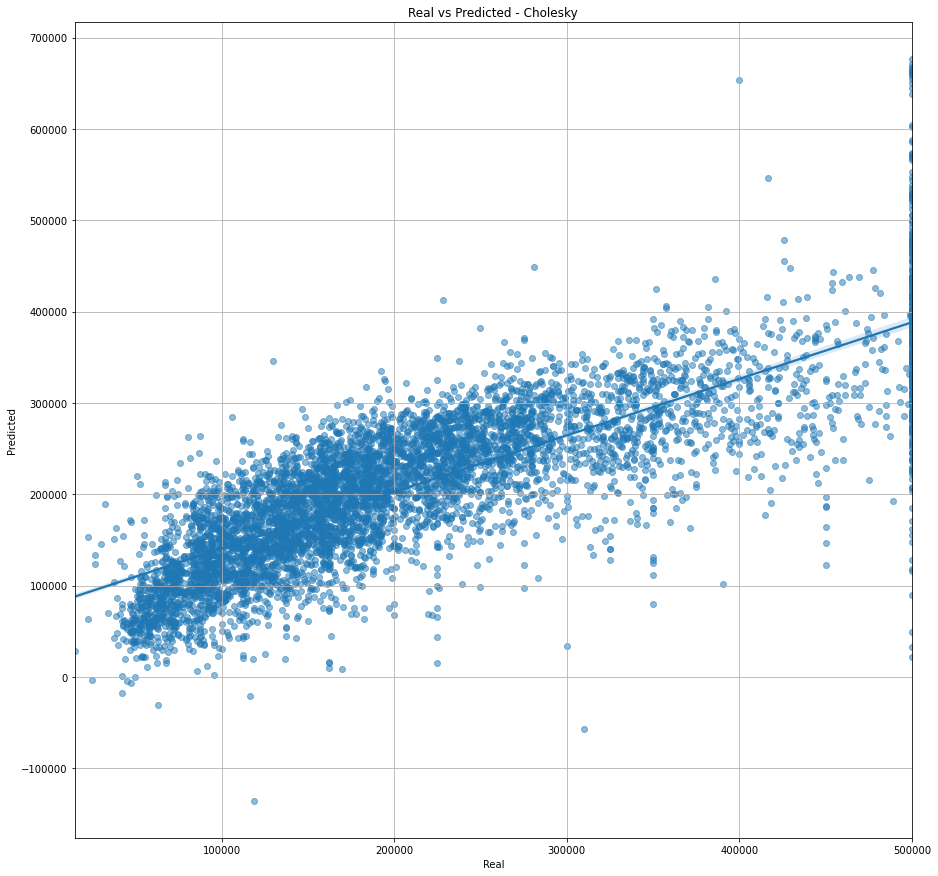

In [39]:
Plotting.regPlot('Cholesky', y_predict_c, y_test)

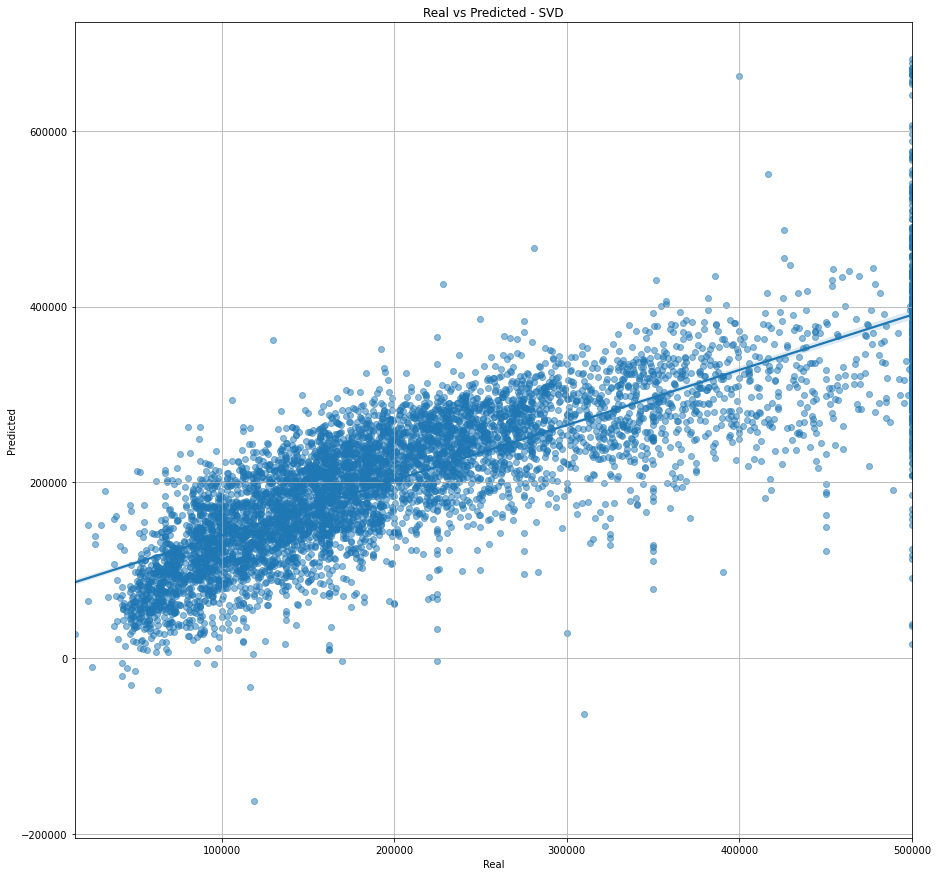

In [40]:
Plotting.regPlot('SVD', y_predict_s, y_test)

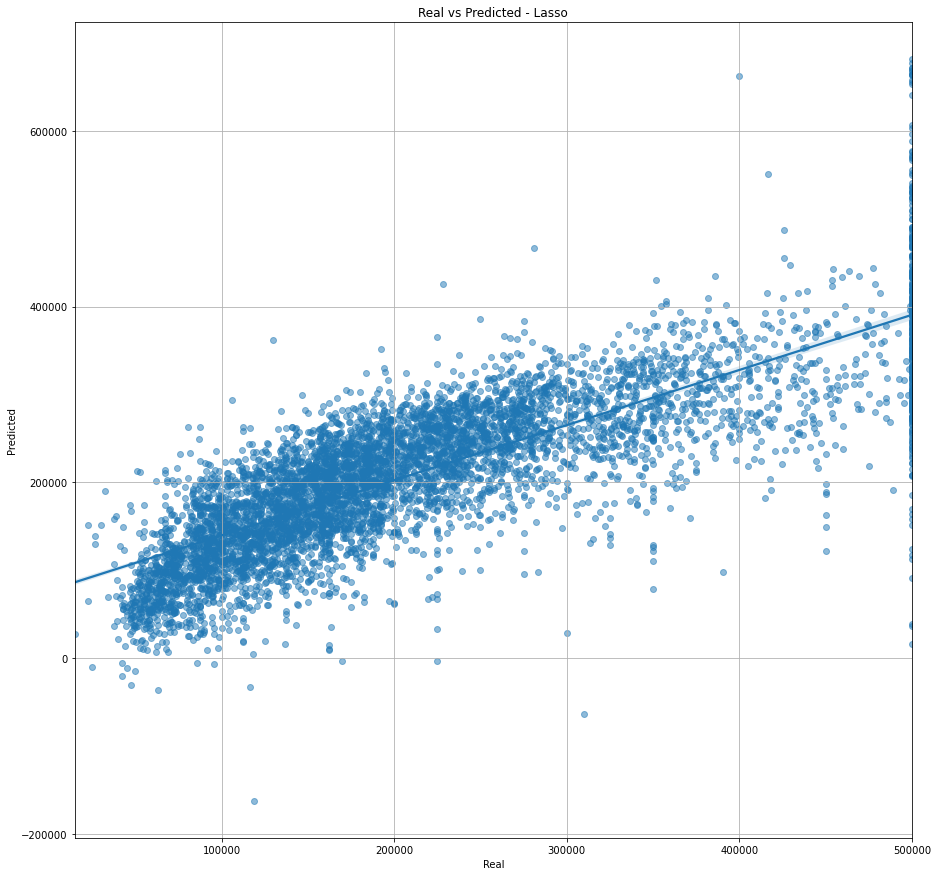

In [41]:
Plotting.regPlot('Lasso', y_predict_l, y_test)

----------------
## Cross-validation

### Cross-validated risk estimate
Cross Validation is is a method that allows to perform selection and  validation of the learning algorithm. 

Set aside a portion of the data for the test set and perform multiple interations on the training data, splitted in k-folds and validate the hyperparameter to one fold per time . Then compare to the test data.

Method for comparing is the root mean squared error.

Normalize to get values normalized

Use the 5-fold cross validation

#### K-Folds cross-validator
Provides train/test indices to split data in train/test sets.

Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [42]:
cholesky.crossValidationKFold(X, y)
svd.crossValidationKFold(X, y)
lasso.crossValidationKFold(X, y)

cholesky.printBestScores()
svd.printBestScores()
lasso.printBestScores()

Cholesky:
-best ɑ: 0.09090909090909083
-best MSE: 4855808814.745185
-best R²: 0.63552489324503
SVD:
-best ɑ: 0.09090909090909083
-best MSE: 4855808814.745185
-best R²: 0.6355248932450301
Lasso:
-best ɑ: 1.0
-best MSE: 4841582602.467993
-best R²: 0.6365927071636308


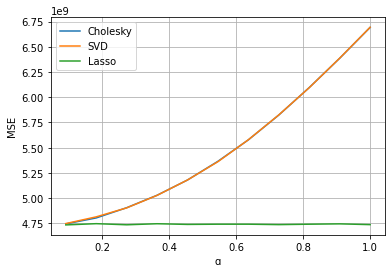

In [43]:
Plotting.plotXY(alphas, [cholesky.MSE, svd.MSE, lasso.MSE], [cholesky.algo, svd.algo, lasso.algo], 'ɑ', 'MSE')

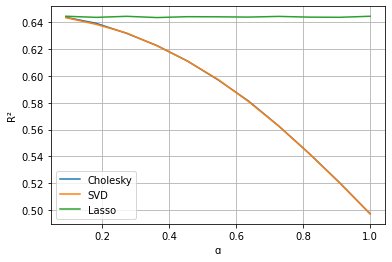

In [44]:
Plotting.plotXY(alphas, [cholesky.R2, svd.R2, lasso.R2], [cholesky.algo, svd.algo, lasso.algo], 'ɑ', 'R²')

----------------
## Nested cross-validation

### GridSearchCV
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [45]:
cholesky.nestedCrossValidationKFold(X, y)

Average difference of 0.000171 with std. dev. of 0.000492.


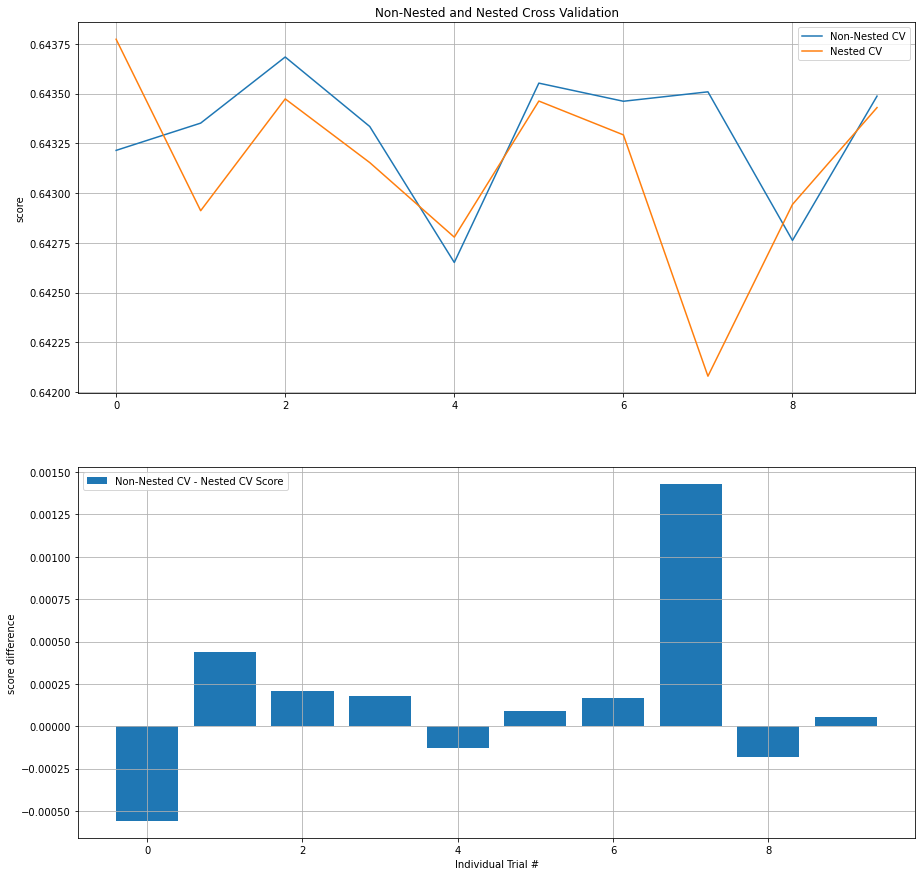

In [46]:
Plotting.plotNestedCrossVal(
    cholesky.nested_cross_validation_trials,
    cholesky.nested_scores,
    cholesky.non_nested_scores,
    cholesky.score_difference)

----------------
## Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the regression.

In [47]:
data_frameOriginal

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0,1,0,0,0


In [48]:
X = data_frameOriginal.drop(columns=[column_to_predict])
y = data_frameOriginal[column_to_predict]

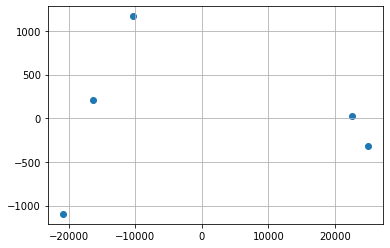

In [49]:
coef_pca = cholesky.fitPCABySize(sizes, X, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])

In [50]:
X_pca = cholesky.fitPCA(X.shape[1], X)

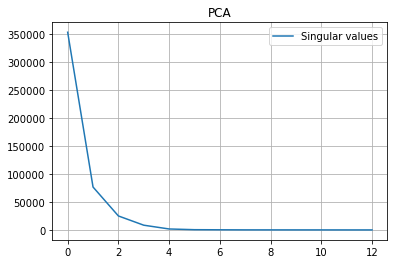

In [51]:
Plotting.plot('PCA', cholesky.pca_singular_values, 'Singular values')

We project all the datapoints on the five principal components. Then we check the learning curve again.

In [52]:
X_pca = cholesky.fitPCA(5, X)
train_size, train_score, val_score = learning_curve(cholesky, X_pca, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=-1)

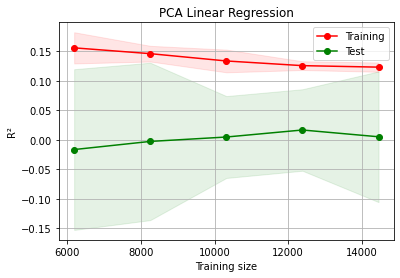

In [53]:
Plotting.plotAreaMeanStd(
    'PCA Linear Regression', 
    sizes, 
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

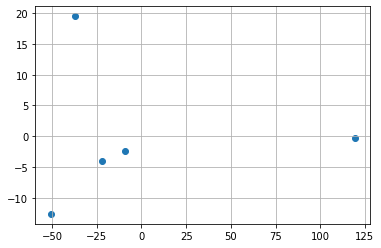

In [54]:
coef_pca = cholesky.fitPCABySize(sizes, X_pca, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])

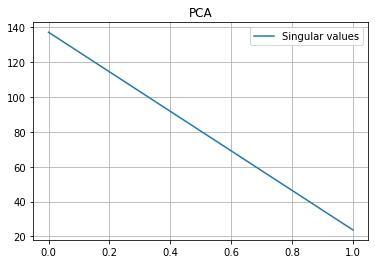

In [55]:
Plotting.plot('PCA', cholesky.pca_singular_values, 'Singular values')

We project all the datapoints on the five principal components. Then we check the learning curve again.

In [56]:
train_size, train_score, val_score = cholesky.learningCurvePCA(sizes, 5, X, y, scoring)

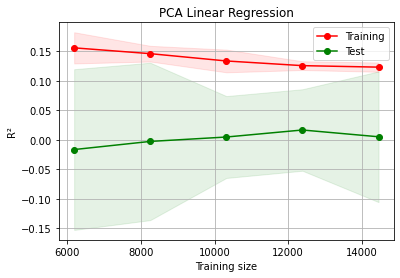

In [57]:
Plotting.plotAreaMeanStd(
    'PCA Linear Regression',
    sizes,
    [train_score, val_score],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

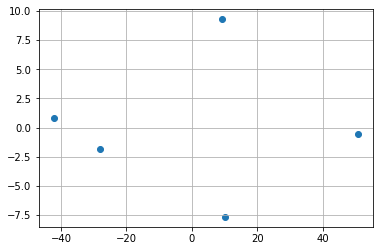

In [58]:
coef_pca = cholesky.fitPCABySize(sizes, X_pca, y, 2)
Plotting.scatterPlot(coef_pca[:,0], coef_pca[:,1])